# 2D Water Waves using Python
Gravity waves in water follow a perhaps enigmatic dispersion relation. The phase speed $c_p$ is given by
$$
c_p^2 = \left(\frac{\omega}{k} \right)^2 = \frac{g}{k} \tanh (kd),
$$
where $g$ is the acceleration of gravity and $d$ is the water depth. This relation captures subsurface hydrodynamics that are not reducible to a wave equation of finite order for the water surface $z(x,y,t)$. However, given the dispersion relation, an efficient model of linear wave evolution may be implemented using the fast Fourier transform (FFT).

## Linear waves in 2D

Homogeneous Neumann boundary conditions on a square “lake” of width $W$ is satisfied by decomposing the instantaneous waveform as a cosine series, 
$$
    z(x,y) = \sum_{m,n} \tilde{z}_{m,n} \cos(k_xx) \cos(k_yy).
$$
Each mode is indexed by quantum numbers $m,n \in \{ 1,2,3,...N\}$. The choice of some finite $N$ specifies the resolution of our model, $N\times N$ sampling on domain $x,y \in [0,W]$.
The allowed wavenumbers are, e.g.,
$$
    k_x = \frac{m π}{W},
$$
and similarly for $k_y$, which is indexed by $n$. Coefficients $\tilde{z}_{m,n}$ are readily obtained for an arbitrary surface waveform $z(x,y)$ by the 2D discrete cosine transform (DCT), which is provided by typical FFT libraries. 

The time dependence of each mode $(m,n)$ is independent of the rest. It enters through the DCT coefficients, 
$$
    \tilde{z}_{m,n}(t) = A_{m,n} \cos(\omega t + \varphi_{m,n}),   \quad(1)
$$
where $A_{m,n}$ is the scalar amplitude in meters for mode $(m,n)$. The frequency $\omega$ also depends on $(m,n)$. In terms of the scalar wavenumber 
$$
    k \equiv \sqrt{k_x^2+k_y^2} = \frac{\pi}{W}\sqrt{m^2 + n^2}\,,
$$
the frequency is given by solving the water wave dispersion relation to obtain
$$
    \omega = \sqrt{ gk\,\tanh(kd) }.
$$
We require only the positive square root (positive frequency) because the phase is captured explicitly by $\varphi_{m,n}$.

### Initial conditions
The entire past and futuere time development of an isolated, linear, undamped lake is determined if the state of the system is given at a single time $t=t_1$. The state may be fully specified by two real constants (the value and time derivative of the coefficient) for each mode $(m,n)$:
$$
    \tilde{z}_{m,n}(t_1) = \tilde{z}_{1,m,n}; \quad 
    \dot{\tilde{z}}_{m,n}(t_1) = \tilde{v}_{1,m,n}.
$$
The time dependence $\tilde{z}_{m,n}$ merely requires a sinusoid of frequency $\omega_k$ obeying the above two boundary conditions:
$$
    \boxed{\tilde{z}_{m,n}(t) = 
        \tilde{z}_{1,m,n} \cos\left[ \omega (t-t_1) \right] +
        \frac{\tilde{v}_{1,m,n}}{\omega} \sin\left[ \omega (t-t_1) \right]
        \quad(2)}
$$
The above formulation is probably the most convenient for implementation. To recover equation (1), we can squeeze it all into a cosine by finding the total amplitude, and the phase at time $t_1$:
$$
    A_{m,n} = \sqrt{ \tilde{z}_{1,m,n}^2 + 
        \left( \frac{\tilde{v}_{1,m,n}}{\omega} \right)^2 }; \quad
    \varphi_{k1} = \arctan_2 \left( 
        \tilde{v}_{1,m,n},\omega \tilde{z}_{1,m,n} \right).
$$
Note the use of the two-argument arctangent function, so that there is no phase ambiguity. We now have
$$
    \tilde{z}_{m,n}(t) = A_{m,n} \cos\left[ \omega (t-t_1) + \varphi_{1,m,n} \right].
$$
If we now express the phase at time $t=0$,
$$
    \varphi_{m,n} = \varphi_{1,m,n} - \omega t_1,
$$
the time dependence may be expressed exactly as in equation (1).


In [1]:
# Base libraries
import numpy as np
from scipy.fftpack import dct, idct
# Define 2D transform and its inverse
dct2 = lambda arr: dct(dct(arr, axis=-1, norm='ortho'), axis=-2, norm='ortho')
idct2 = lambda arr: idct(idct(arr, axis=-1, norm='ortho'), axis=-2, norm='ortho')
from mpl_toolkits.mplot3d import Axes3D
# Axes3D has the side effect of enabling projection='3d'
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LightSource
import time
%matplotlib inline

In [2]:
# World parameters
g = 9.81 # m/s^2, accel of gravity
w = 1600 # m, sea width
d = 200 # m, sea depth
N = 256  # edge size of array (power of 2 advised for efficiency)
x = y = np.linspace(-w/2,w/2,num=N) # 1D coordinates, m
dx = x[1]-x[0]
xx,yy = np.meshgrid(x,y)            # 2D Cartesian coordinates, m
rr = np.sqrt(xx**2 + yy**2)         # 2D radial coordinate, m
dk = np.pi/w                        # Fundamental wavenumber (and wavenumber step), rad/m
k = np.arange(N)*dk                 # 1D wavenumber array, rad/m
kx,ky = np.meshgrid(k,k)            # 2D coordinates in wavenumber space, rad/m
kk = np.sqrt(kx**2 + ky**2)            # 2D absolute wavenumber, rad/m
omega = np.sqrt(g*kk*np.tanh(kk*d))  # 2D angular frequency, rad/s, according to water wave dispersion relation
omega_nonzero = (omega != 0)
Nt = 100
dt = 1.0/np.amax(omega)
t = np.arange(Nt)*dt
print(dt)
print(dx)

0.37942239594588884
6.274509803921546


Nominal wave speed:  21.63741247021566  m/s


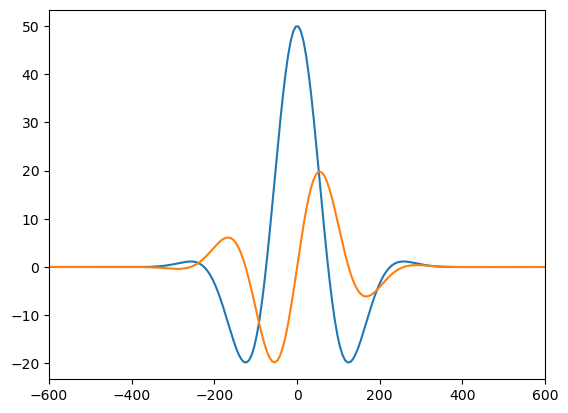

In [3]:
# Test wave
lambda0 = 300
sigma0 = lambda0/3
h0 = 50
k0 = 2*np.pi/lambda0
z0 = h0*np.exp(-x**2/(2*sigma0**2))*np.cos(k0*x)
cp0 = np.sqrt((g/k0)*np.tanh(k0*d))
print('Nominal wave speed: ',cp0,' m/s')
dzdx = (np.roll(z0,-1)-np.roll(z0,1))/(2*dx)
v0 = - cp0 * dzdx
plt.figure()
plt.plot(x,z0)
plt.plot(x,v0)
plt.xlim((-6*sigma0,6*sigma0))
plt.show();

Mean height =  0.8704138372835957


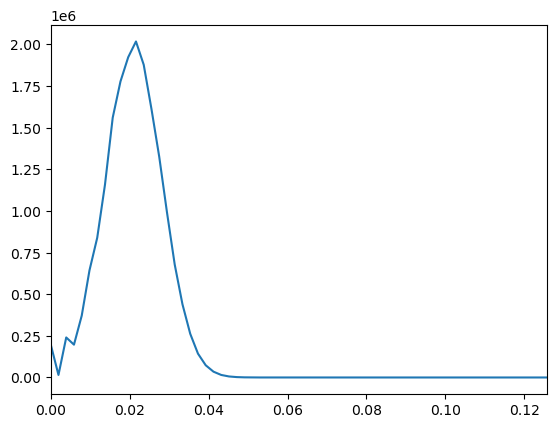

In [4]:
# Power spectral estimation
Nroll = int(np.ceil(lambda0/dx))
z0_ps = np.zeros(N)
norm = 0
for shift in range(-Nroll,Nroll):
    weight = (Nroll-shift)*(Nroll+shift+1)
    z0_ps += weight * dct(np.roll(z0, shift))**2
    norm += weight
z0_ps /= norm
print('Mean height = ',np.mean(z0))

plt.figure()
plt.plot(k,z0_ps)
plt.xlim(0,6*k0)
plt.show();

/var/folders/4b/jg9_zw7h8xj33m00r6bggh880000gn/T/ipykernel_8516/120916999.py:2: RuntimeWarning: divide by zero encountered in divide
  wavelength = 2*np.pi/k


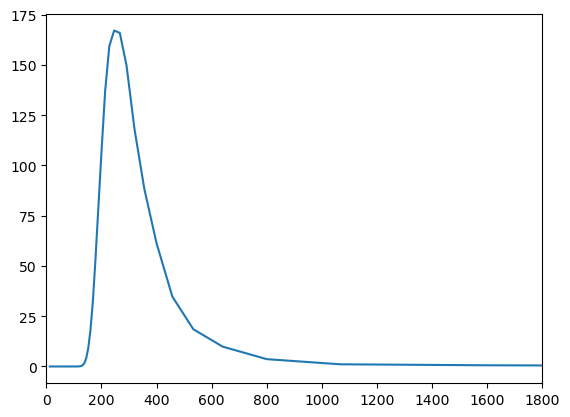

In [5]:
plt.figure()
wavelength = 2*np.pi/k
plt.plot(wavelength, z0_ps*2*np.pi/wavelength**2)
plt.xlim((0,6*lambda0))
plt.show()

In [6]:
# Physics (equation 2)

def sea(Fz0, Fv0, t0, t):
    """
    Given DCT of wave state Fz0, Fv0 at time t0, find the sea height z
    at time t. This follows equation 2. The 1/omega term is infinite for
    omega=0, so that one element is excluded.
    """
    phase = omega*(t-t0)
    Fz = Fz0*np.cos(phase)
    Fz[omega_nonzero] += ( (Fv0[omega_nonzero]/omega[omega_nonzero]) *
               np.sin(phase[omega_nonzero]) )
    
    return  idct2(Fz)

def sea2(Fz0, Fv0, t0, t):
    """
    Given DCT of wave state Fz0, Fv0 at time t0, find the state z, v
    at time t. This follows equation 2. The 1/omega term is infinite for
    omega=0, so that one element is excluded.
    """
    phase = omega*(t-t0)
    Fz = Fz0*np.cos(phase)
    Fz[omega_nonzero] += ( (Fv0[omega_nonzero]/omega[omega_nonzero]) *
               np.sin(phase[omega_nonzero]) )
    Fv = Fv0*np.cos(phase) - omega*Fz0*np.sin(phase)
    # The quantity below puts Fv into units of length by dividing out frequency.
    Fz90 = -Fz0*np.sin(phase)
    #print(Fz90.shape, (Fv0[omega_nonzero]/omega[omega_nonzero]).shape, phase[omega_nonzero].shape)
    #print(omega_nonzero.shape, phase.shape, Fv0.shape)
    #print((Fv0[omega_nonzero]).shape)
    Fz90[omega_nonzero] += ( (Fv0[omega_nonzero]/omega[omega_nonzero]) *
               np.cos(phase[omega_nonzero]) )
    return  idct2(Fz), idct2(Fv), idct2(Fz90)



In [7]:
# 3D test wave

# Initial plop
t0 = t[0]
z0 = np.zeros(xx.shape)
Fz0 = dct2(z0)
rp2=(xx-w/3)**2 + (yy+w/7)**2 # radial coord centered on plop
v0 = -10*np.exp(-rp2/(2*(w/30)**2))
Fv0 = dct2(v0)

# Superimpose initial conditions leading to a final waterspout
#t1 = t[-100]
#rs2=(xx+w/13)**2 + (yy-w/5)**2 # radial coord centered on spout
#z1 = 20*np.exp(-rs2/(2*(w/30)**2))
#Fz1 = dct2(z1)
#v1 = np.zeros(xx.shape)
#Fv1 = dct2(v1)
#zz,vv,z90 = sea2(Fz1,Fv1,t1,t0)
#Fz0 += dct2(zz)
#Fv0 += dct2(vv)


/Users/kankel/anaconda3/envs/chance/lib/python3.12/site-packages/scipy/stats/_entropy.py:350: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n/(2*m) * differences)


Execution time:  2  seconds


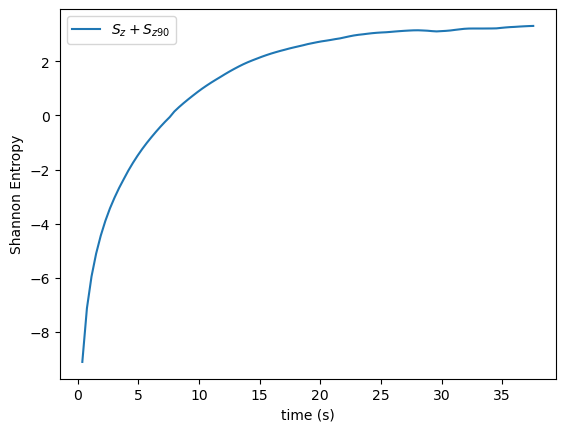

In [8]:
# Work up statistics of the solution, but not keeping solution in memory.
# Determine what should be the plot range. Solving the wave equation
# is quick enough that it doesn't matter I solve the problem more than once
# in the notebook.
from scipy import stats
plotmin = 0
plotmax = 0
ta = time.time()
zentropy = np.empty((Nt))
ventropy = np.empty((Nt))
z90entropy = np.empty((Nt))
for i in range(Nt):
    zz,vv,z90 = sea2(Fz0, Fv0, t0, t[i])
    zentropy[i] = stats.differential_entropy(zz.flatten())
    ventropy[i] = stats.differential_entropy(vv.flatten())
    z90entropy[i] = stats.differential_entropy(z90.flatten())
    zzmin = np.amin(zz)
    zzmax = np.amax(zz)
    if zzmin < plotmin:
        plotmin = zzmin
    if zzmax > plotmax:
        plotmax = zzmax
tb = time.time()
print('Execution time: ', round(tb-ta),' seconds')

%matplotlib inline
plt.figure()
# plt.plot(t, zentropy, label='$S_z$')
# plt.plot(t, ventropy, label='$S_v$')
# plt.plot(t, z90entropy, label='$S_{z90}$')
plt.plot(t, zentropy+z90entropy, label='$S_z + S_{z90}$')
plt.xlabel('time (s)')
plt.ylabel('Shannon Entropy')
plt.legend()
plt.show();

In [9]:
%matplotlib inline
# Movie
from celluloid import Camera
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set(xlabel='$x$ (m)',
       ylabel='$y$ (m)',
       zlabel='$z$ (m)')
ls = LightSource(335,45)
camera = Camera(fig)

for i in range(Nt):
    zz = sea(Fz0, Fv0, t0, t[i])
    rgb = ls.shade(zz, cmap=cm.winter)
    ax.plot_surface(xx,yy,zz, antialiased=True, rstride=1, cstride=1,
                   facecolors=rgb)
    ax.set(zlim=(plotmin,plotmax));
    ax.set(title='Time: {:3.1f} s'.format(t[i]))
    camera.snap()
    
plt.close(fig)
tc=time.time()
print('Execution time: ', round((tc-tb)/60),' minutes')

Execution time:  4  minutes


In [10]:
animation = camera.animate()
%time animation.save('test_2d_waves.mp4', fps=30, dpi=150)

CPU times: user 14min 38s, sys: 57.9 s, total: 15min 36s
Wall time: 8min 8s


In [11]:
from IPython.display import Video
Video('test_2d_waves.mp4', width=768)